In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.cmvae import CMVAE

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Generate Data with Partial Mediation

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z} &\sim \mathcal{N}(0, \sigma^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{x} &= f(\boldsymbol{z}) + c_2 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z} + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ is a nonlinear function which is modeled by an **un-trained** multi-layer perceptron (MLP), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 3000
p, c1, c2, sigma, noise_scale = 0.5, 4, 0.1, 1, 0.01
x_dim, z_dim, hidden_dim = 50, 10, 25
f = nn.Sequential(
    nn.Linear(z_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)

T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
Z0 = np.random.multivariate_normal(mean=np.zeros(z_dim), cov=sigma*np.eye(z_dim), size=N)
Z1 = Z0 + c1
Z = np.array([Z0[i,:] if T[i][0] == 0 else Z1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z).float()).numpy()
    X += c2 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_dim)
Y = (alpha * T.reshape(-1) + Z @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [3]:
Y0_M0 = (alpha * np.zeros(N) + Z0 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z1 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y1_M0 = (alpha * np.ones((N)) + Z0 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z1 @ beta + noise_scale * np.random.normal(size=N)).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 4.7044
True ACME (treatment) = 4.7042
True ADE (control) = -0.7401
True ADE (treatment) = -0.7403
True ATE = 3.9641


# 2. Fit CMVAE model and evaluate mediation effect

In [4]:
cmvae = CMVAE(n_components=10, n_sup_networks=10, n_hidden_layers=1, hidden_dim=25, 
              optim_name='AdamW', weight_decay=0.0, recon_weight=1.0, elbo_weight=1.0)
_ = cmvae.fit(
    X, T, Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=True
)
acme_c_mean, acme_c_std = cmvae.acme_score(X.shape[0], treatment=False)
acme_t_mean, acme_t_std = cmvae.acme_score(X.shape[0], treatment=True)
ade_c_mean, ade_c_std = cmvae.ade_score(X.shape[0], treatment=False)
ade_t_mean, ade_t_std = cmvae.ade_score(X.shape[0], treatment=True)
ate_mean, ate_std = cmvae.ate_score(X.shape[0])
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))

Beginning Training


Epoch: 199, Current Training MSE: 0.0148278, Current Pred Metric: [1.1393352, 1.


Saving the last epoch with training MSE: 0.0148278 and Pred Metric: [1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352, 1.1393352]
ACME (control) = 4.5956 +/- 0.0256
ACME (treatment) = 4.6008 +/- 0.0331
ADE (control) = -0.4699 +/- 0.0000
ADE (treatment) = -0.4699 +/- 0.0000
ATE = 4.1308 +/- 0.0272


### 2.1 Does the latent feature learned by CMVAE recover the true mediator?

Text(0.5, 1.0, 'Mediator estimated by CMVAE')

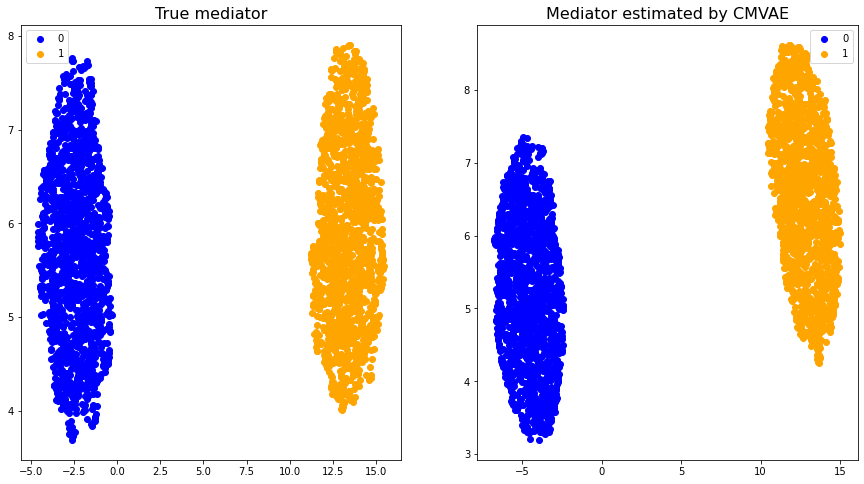

In [8]:
reducer_true, reducer_cmvae = umap.UMAP(), umap.UMAP()
embedding_true = reducer_true.fit_transform(Z)
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z0 = cmvae.prior_dist.sample(*cmvae.ivae.prior_params(t0))
    z1 = cmvae.prior_dist.sample(*cmvae.ivae.prior_params(t1))
    z = torch.stack([z0[i,:] if T[i,0] == 0 else z1[i,:] for i in range(N)])
embedding_cmvae = reducer_cmvae.fit_transform(np.array(z))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,8))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(embedding_true[i,0], embedding_true[i,1], c=c_dict[g], label=g)
    axs[1].scatter(embedding_cmvae[i,0], embedding_cmvae[i,1], c=c_dict[g], label=g)
axs[0].legend()
axs[0].set_title("True mediator", size=16)
axs[1].legend()
axs[1].set_title("Mediator estimated by CMVAE", size=16)